# mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive

MyDrive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [ ]:
! ls

 knowledge_distillation
 mind_dataset
 mind_news_data_process.ipynb
'mind_news_knowledge_distillation _category.ipynb'
 mind_news_knowledge_distillation_ctr.ipynb
 README.md
 restricted_boltzmann_machines_movie_recommendation.ipynb
 wip_jupyter_notebooks


# Install transformer

https://huggingface.co/transformers/installation.html

In [ ]:
! pip install transformers
# ! pip install sentencepiece

     |████████████████████████████████| 2.5MB 25.0MB/s 
     |████████████████████████████████| 3.3MB 42.4MB/s 
     |████████████████████████████████| 901kB 39.6MB/s 


# Import modules

In [ ]:
import os
import re
import time
import random
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from wordcloud import WordCloud

import torch
from torch import nn
import torch.nn.functional as F
import torchtext
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [ ]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"
filename_train = data_path_train + "news_click_df.csv"
filename_test = data_path_test + "news_click_df.csv"
select_text_flag = "title"
select_label_flag = "category_flag" # category_flag # click_prob_flag
model_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/knowledge_distillation/trained_models/"

## set up environment

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [ ]:
ls knowledge_distillation/

data_process.py      model_evaluation.py  __pycache__/
__init__.py          model_kd.py          set_up_environment.py
model_distilbert.py  model_lstm.py        trained_models/
model_doc2vec.py     model_word2vec.py


In [ ]:
from knowledge_distillation.set_up_environment import set_random_seed, set_up_gpu

In [ ]:
set_random_seed(999)
# device = set_up_gpu()
# print(device)

In [ ]:
# Clear memory
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

# Set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      

In [ ]:
import torch
torch.backends.cudnn.enabled=False

# process data

In [ ]:
from knowledge_distillation.data_process import DataProcessing

In [ ]:
dp = DataProcessing()
data_df_train = dp.get_data(data_path_train, select_text_flag, select_label_flag)
data_df_test = dp.get_data(data_path_test, select_text_flag, select_label_flag)

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",1


In [ ]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())
print("num_classes", num_classes)

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
select_data_df_train.head(2)

num_classes 2
1    32020
0      815
Name: label, dtype: int64
1    21579
0      677
Name: label, dtype: int64


,text,label
0,Should NFL be able to fine players for criticizing officiating?,1
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


In [ ]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
1    32020
0      815
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
1    21579
0      677
Name: label, dtype: int64


# generate models

In [ ]:
from knowledge_distillation.model_doc2vec import Doc2vecModelling, Doc2vecModelPrediction
from knowledge_distillation.model_distilbert import DistilBERTModelling
from knowledge_distillation.model_word2vec import Word2vecModelling
from knowledge_distillation.model_lstm import LstmModelling
from knowledge_distillation.model_kd import KnowledgeDistillationModelling
from knowledge_distillation.model_evaluation import plot_confusion_matrix_heatmap

In [ ]:
# set up parameters
num_epochs = 10
batch_size = 32

In [ ]:
kd = KnowledgeDistillationModelling
dv = Doc2vecModelling
db = DistilBERTModelling
lm = LstmModelling
wv = Word2vecModelling

## Doc2vec Model

(32835, 24)
(22256, 24)
(32835,)
(22256,)
24 2
epoch:  0 	 loss:  118.94858751539141
epoch:  1 	 loss:  108.22449593059719
epoch:  2 	 loss:  106.64069746341556
epoch:  3 	 loss:  106.14845122536644
epoch:  4 	 loss:  105.97422649804503
epoch:  5 	 loss:  105.90705869859084
epoch:  6 	 loss:  105.8793783672154
epoch:  7 	 loss:  105.86715059960261
epoch:  8 	 loss:  105.86121982056648
epoch:  9 	 loss:  105.85793112264946
time :  21.64920735359192
time :  1.8487613201141357
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99     32835

    accuracy                           0.98     32835
   macro avg       0.50      0.49      0.49     32835
weighted avg       1.00      0.98      0.99     32835

predicted label:  {1}
Accuracy: 0.9751789249276687
Precision: 0.9509739356230836
Recall: 0.9751789249276687
F1 Score: 0.9629243443430406


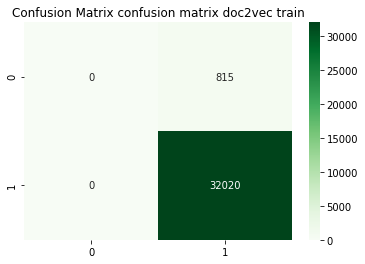

precision_score 0.9751789249276687
roc_auc_score-auc: 0.5
roc_curve-fpr: [0. 1.]
roc_curve-tpr: [0. 1.]


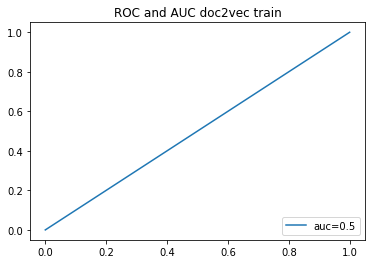

time :  1.2804508209228516
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.98     22256

    accuracy                           0.97     22256
   macro avg       0.50      0.48      0.49     22256
weighted avg       1.00      0.97      0.98     22256

predicted label:  {1}
Accuracy: 0.9695812365204889
Precision: 0.9400877742126001
Recall: 0.9695812365204889
F1 Score: 0.9546067527261608


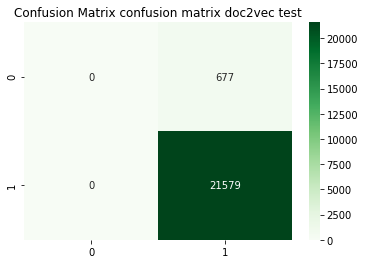

precision_score 0.9695812365204889
roc_auc_score-auc: 0.5
roc_curve-fpr: [0. 1.]
roc_curve-tpr: [0. 1.]


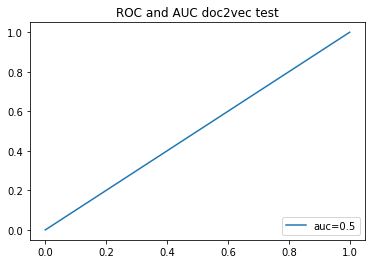

In [ ]:
# select data
train_text, train_label, test_text, test_label = dv.select_data(select_data_df_train, select_data_df_test)
# generate doc2vec model
doc2vec_model = dv.generate_doc2vec_model(data_path_train, train_text, 100)
# process train and test data
train_x, train_y, test_x, test_y, train_loader, test_loader = dv.process_data(doc2vec_model, train_text, train_label, test_text, test_label)
# classify data using simple neural network
num_labels = len(set(train_y))
vocab_size = train_x.shape[1]
print(vocab_size, num_labels)
nn_model, train_loader = dv.classfiy_model_neural_network(train_loader, num_labels, vocab_size, num_epochs)

dvmp = Doc2vecModelPrediction
dvmp.predict_texts_nn(nn_model, train_loader, "doc2vec train", num_classes)
dvmp.predict_texts_nn(nn_model, test_loader, "doc2vec test", num_classes)

## DistilBERT Model

In [ ]:
filename_train, filename_test

('/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv',
 '/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Size of TEXT vocabulary: 462207
Size of LABEL vocabulary: 3
epoch:  0 	 loss:  44.375348894973285
epoch:  1 	 loss:  20.425741518905852
epoch:  2 	 loss:  11.455039840224345
epoch:  3 	 loss:  4.83050418608218
epoch:  4 	 loss:  1.9292044020149888
epoch:  5 	 loss:  1.1378122142797338
epoch:  6 	 loss:  2.3646072757464935
epoch:  7 	 loss:  1.3056668252613122
epoch:  8 	 loss:  0.7723820665828214
epoch:  9 	 loss:  0.26483628901019785
time :  227.71998500823975
time :  16.97797966003418
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       815
           1       1.00      1.00      1.00     32020

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999390893863256
Precision: 0.9999390893863256
Recall: 0.9999390893863256
F1 Score: 0.9999390893863256


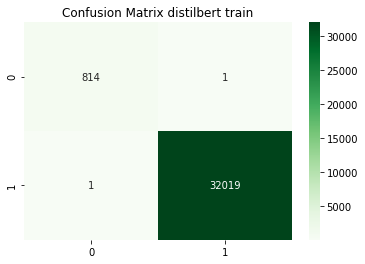

precision_score 0.9999679953202812
roc_auc_score-auc: 0.99937088782701
roc_curve-fpr: [0.         0.00122699 1.        ]
roc_curve-tpr: [0.         0.99996877 1.        ]


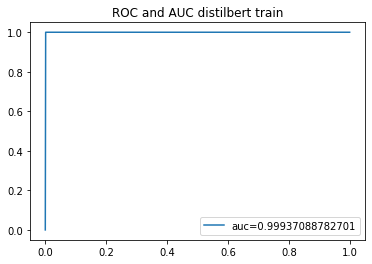

time :  11.379374027252197
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       679
           1       1.00      1.00      1.00     21577

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9997304097771388
Precision: 0.9997309308343736
Recall: 0.9997304097771388
F1 Score: 0.9997306023431106


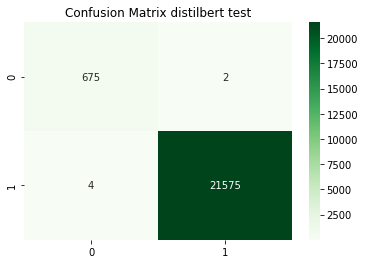

precision_score 0.9999016873037984
roc_auc_score-auc: 0.99843021242478
roc_curve-fpr: [0.         0.00295421 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


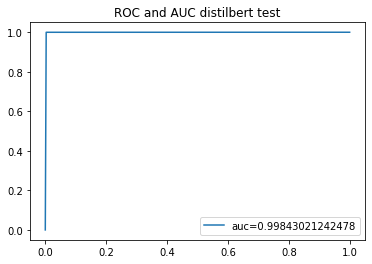

In [ ]:
tokenizer  = db.get_tokenizer("distilbert-base-uncased")
distilbert_model = db.generate_model(num_classes)

train_iter_db, test_iter_db = db.process_text(tokenizer, 
                                              filename_train, filename_test, batch_size)

distilbert_model, device = db.train_distilbert(distilbert_model, device, 
                                               train_iter_db, num_classes, num_epochs)

db.predict_distilbert(distilbert_model, device, train_iter_db, "distilbert train", num_classes)
db.predict_distilbert(distilbert_model, device, test_iter_db, "distilbert test", num_classes)

# LSTM Model

Size of TEXT vocabulary: 9554
Size of LABEL vocabulary: 2
[('to', 8724), ('the', 8393), ('in', 6132), ('for', 5027), ('of', 3962), ('on', 3194), ('a', 2961), ('and', 2789), ('with', 2643), ('at', 2346)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f0cd4fe2250>>, {'<unk>': 0, '<pad>': 1, 'to': 2, 'the': 3, 'in': 4, 'for': 5, 'of': 6, 'on': 7, 'a': 8, 'and': 9, 'with': 10, 'at': 11, 'vs': 12, 'week': 13, 'game': 14, 'football': 15, 'after': 16, 'is': 17, 'from': 18, 'win': 19, 'as': 20, 'state': 21, 'over': 22, 'no': 23, 'out': 24, 'will': 25, 'report': 26, 'season': 27, 'nfl': 28, 'be': 29, 'patriots': 30, 'nt': 31, 'his': 32, 'watch': 33, 'how': 34, 'new': 35, 'against': 36, 'injury': 37, 'has': 38, 'what': 39, 'loss': 40, 'he': 41, 'astros': 42, 'up': 43, 'are': 44, 'this': 45, 'not': 46, 'by': 47, 'team': 48, 'eagles': 49, 'about': 50, 'first': 51, 'have': 52, 'michigan': 53, 'world': 54, 'it': 55, 'back': 56, 'high': 57, 'series': 

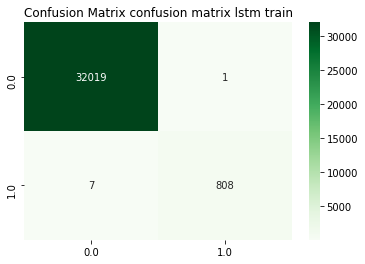

precision_score 0.9903987529073
roc_auc_score-auc: 0.995689906231918
roc_curve-fpr: [0.00000000e+00 3.12304809e-05 1.00000000e+00]
roc_curve-tpr: [0.         0.99141104 1.        ]


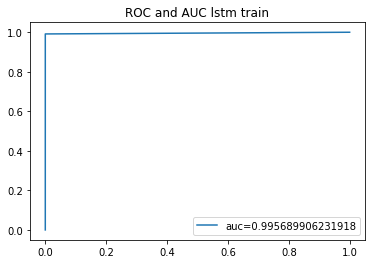

time :  1.111980676651001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21583
           1       0.98      0.99      0.99       673

    accuracy                           1.00     22256
   macro avg       0.99      0.99      0.99     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9991013659237958
Precision: 0.9990993294249342
Recall: 0.9991013659237958
F1 Score: 0.9991000762541106


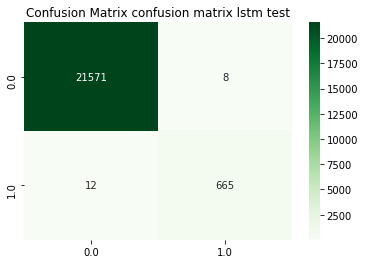

precision_score 0.9711375505823053
roc_auc_score-auc: 0.9909520053517757
roc_curve-fpr: [0.00000000e+00 3.70730803e-04 1.00000000e+00]
roc_curve-tpr: [0.         0.98227474 1.        ]


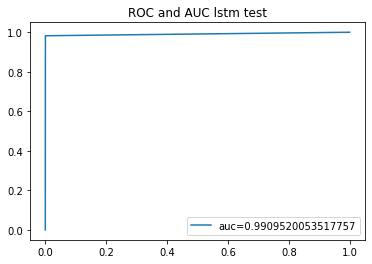

LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
train_iter_lm, test_iter_lm = lm.process_text(filename_train, filename_test, batch_size)
lstm_model = lm.generate_model(num_classes)
lstm_model, device = lm.train(lstm_model, device, train_iter_lm, 
                              num_classes, num_epochs, token_flag="lstm")
lm.predict(lstm_model, device, train_iter_lm, "lstm", "lstm train", num_classes)
lm.predict(lstm_model, device, test_iter_lm, "lstm", "lstm test", num_classes)
lstm_model

## Simple Embedding Model

Size of TEXT vocabulary: 22507
Size of LABEL vocabulary: 2
[('to', 8724), ('the', 8393), ('in', 6132), ('for', 5027), ('of', 3962), ('on', 3194), ('a', 2961), ('and', 2789), ('with', 2643), ('at', 2346)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f0cd1ddca10>>, {'<unk>': 0, '<pad>': 1, '(sos)': 2, '(eos)': 3, 'to': 4, 'the': 5, 'in': 6, 'for': 7, 'of': 8, 'on': 9, 'a': 10, 'and': 11, 'with': 12, 'at': 13, 'vs': 14, 'week': 15, 'game': 16, 'football': 17, 'after': 18, 'from': 19, 'is': 20, 'win': 21, 'as': 22, 'state': 23, 'over': 24, 'no': 25, 'out': 26, 'will': 27, 'report': 28, 'season': 29, 'nfl': 30, 'be': 31, 'patriots': 32, 'his': 33, 'watch': 34, 'how': 35, 'new': 36, 'against': 37, 'injury': 38, 'loss': 39, 'has': 40, 'astros': 41, 'up': 42, 'this': 43, 'not': 44, 'by': 45, 'what': 46, 'are': 47, 'team': 48, 'eagles': 49, 'about': 50, 'first': 51, 'have': 52, 'michigan': 53, 'world': 54, 'back': 55, 'it': 56, 'high': 57, 'se

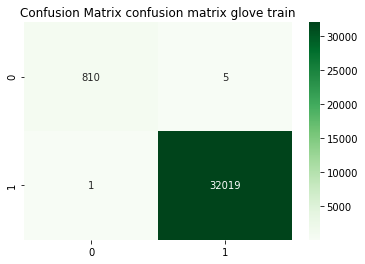

precision_score 0.9998430968016685
roc_auc_score-auc: 0.9969169000969487
roc_curve-fpr: [0.         0.00613497 1.        ]
roc_curve-tpr: [0.         0.99996877 1.        ]


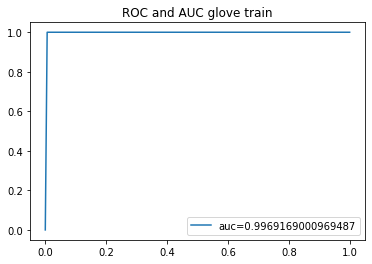

time :  0.3614819049835205
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       670
           1       1.00      1.00      1.00     21586

    accuracy                           1.00     22256
   macro avg       0.99      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9995057512580877
Precision: 0.999504943522463
Recall: 0.9995057512580877
F1 Score: 0.9995045070943648


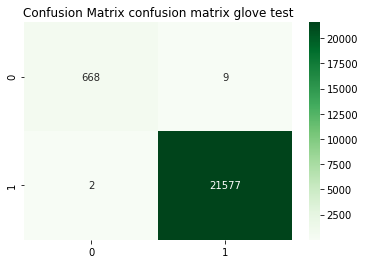

precision_score 0.9995802824461362
roc_auc_score-auc: 0.9933066867146056
roc_curve-fpr: [0.         0.01329394 1.        ]
roc_curve-tpr: [0.         0.99990732 1.        ]


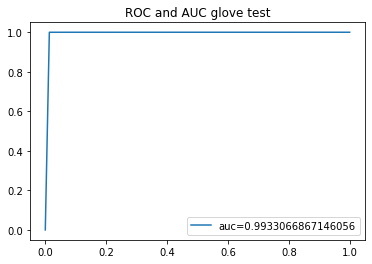

In [ ]:
train_iter_mv, test_iter_mv = wv.process_text(filename_train, filename_test, batch_size)
glove_model = wv.generate_model(num_classes)
glove_model, device = wv.train_embedding(glove_model, device, train_iter_mv, num_classes, num_epochs)
wv.predict_embedding(glove_model, device, train_iter_mv, "glove train", num_classes)
wv.predict_embedding(glove_model, device, test_iter_mv, "glove test", num_classes)

# knowledge distillation

In [ ]:
token_name = "distilbert"
tokenizer  = db.get_tokenizer("distilbert-base-uncased")
train_iter_kd, test_iter_kd = db.process_text(tokenizer, 
                                              filename_train, filename_test, batch_size)

# train_iter_kd, test_iter_kd = lm.process_text(filename_train, filename_test, batch_size)

Size of TEXT vocabulary: 462207
Size of LABEL vocabulary: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model_name:  distilbert
token_name:  distilbert
epoch:  0 	 loss:  40.73167595754785
epoch:  1 	 loss:  20.11992183154507
epoch:  2 	 loss:  10.929617413758024
epoch:  3 	 loss:  3.926096525297453
epoch:  4 	 loss:  2.2835531522040924
epoch:  5 	 loss:  1.1720737044958867
epoch:  6 	 loss:  1.3981562343829097
epoch:  7 	 loss:  0.9345323642560928
epoch:  8 	 loss:  1.0374155989377725
epoch:  9 	 loss:  1.1218115324865598
time :  626.4644286632538
time :  17.564531564712524
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       790
           1       1.00      1.00      1.00     32045

    accuracy                           1.00     32835
   macro avg       0.98      1.00      0.99     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9991777067153952
Precision: 0.9991773606945649
Recall: 0.9991777067153952
F1 Score: 0.9991714630032972


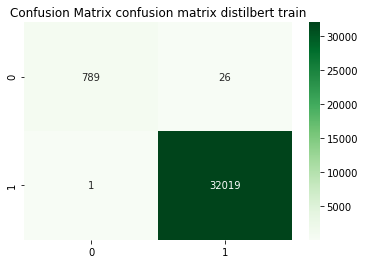

precision_score 0.9991878911386511
roc_auc_score-auc: 0.9840334645141265
roc_curve-fpr: [0.         0.03190184 1.        ]
roc_curve-tpr: [0.         0.99996877 1.        ]


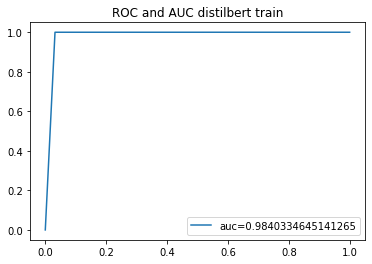

time :  11.796270847320557
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       659
           1       1.00      1.00      1.00     21597

    accuracy                           1.00     22256
   macro avg       0.98      1.00      0.99     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.998921639108555
Precision: 0.9989187437137859
Recall: 0.998921639108555
F1 Score: 0.9989145994847509


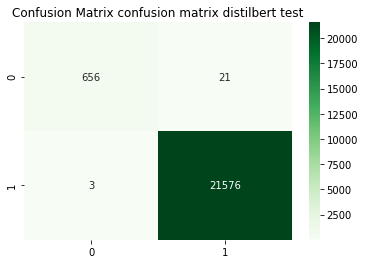

precision_score 0.9990235489694737
roc_auc_score-auc: 0.9844208867927356
roc_curve-fpr: [0.        0.0310192 1.       ]
roc_curve-tpr: [0.         0.99986098 1.        ]


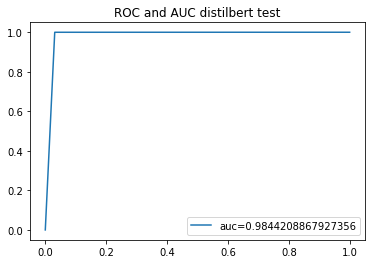

In [ ]:
distilbert_model2 = db.generate_model(num_classes)
distilbert_model2, device = kd.train(distilbert_model2, device, 
                                    train_iter_kd, "distilbert", token_name, 
                                    num_classes, num_epochs, model_path)

kd.predict(distilbert_model2, device, train_iter_kd, token_name, "distilbert train", num_classes)
kd.predict(distilbert_model2, device, test_iter_kd, token_name, "distilbert test", num_classes)

LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
model_name:  lstm
token_name:  distilbert
epoch:  0 	 loss:  103.84725488186814
epoch:  1 	 loss:  28.0045252146665
epoch:  2 	 loss:  8.567984419380082
epoch:  3 	 loss:  3.5381922318047145
epoch:  4 	 loss:  1.2726740923117177
epoch:  5 	 loss:  1.1836550305652054
epoch:  6 	 loss:  3.0037549462713287
epoch:  7 	 loss:  0.9781277604779461
epoch:  8 	 loss:  1.5536912590005159
epoch:  9 	 loss:  0.3828052062108327
time :  1619.0598418712616
time :  2.5189335346221924
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       817
           1       1.00      1.00      1.00     32018

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0

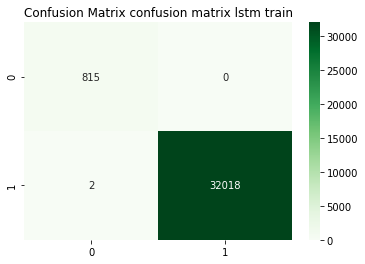

precision_score 0.9999984496517756
roc_auc_score-auc: 0.9999687695190507
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.99993754 1.        ]


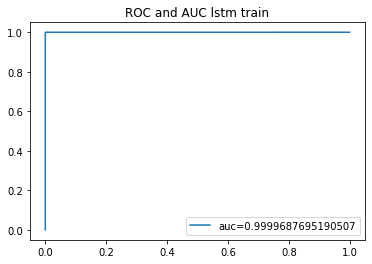

time :  1.641444444656372
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       677
           1       1.00      1.00      1.00     21579

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9996405463695184
Precision: 0.9996405463695184
Recall: 0.9996405463695184
F1 Score: 0.9996405463695184


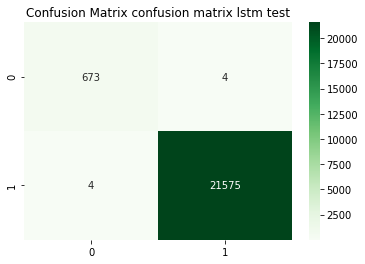

precision_score 0.9998090303724774
roc_auc_score-auc: 0.996953107550334
roc_curve-fpr: [0.         0.00590842 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


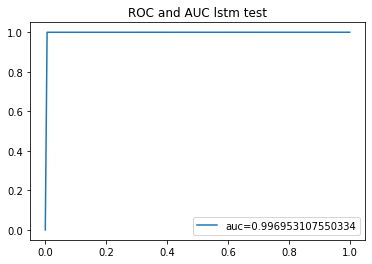

In [ ]:
lstm_model2 = lm.generate_model(num_classes)
lstm_model2, device = kd.train(lstm_model2, device, train_iter_kd, 
                                  "lstm", token_name, num_classes, num_epochs, model_path)
kd.predict(lstm_model2, device, train_iter_kd, token_name, "lstm train", num_classes)
kd.predict(lstm_model2, device, test_iter_kd, token_name, "lstm test", num_classes)

2 30000
EmbeddingBagModel(
  (embedding): EmbeddingBag(30000, 128, mode=mean)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
model_name:  glove
token_name:  distilbert
epoch:  0 	 loss:  103.38847102690488
epoch:  1 	 loss:  24.95782072804286
epoch:  2 	 loss:  8.691613726332434
epoch:  3 	 loss:  3.692745163963991
epoch:  4 	 loss:  1.672088918823647
epoch:  5 	 loss:  0.8676151430504433
epoch:  6 	 loss:  0.5518169370252508
epoch:  7 	 loss:  0.4110502740586597
epoch:  8 	 loss:  0.31989531386935255
epoch:  9 	 loss:  0.2968968452625518
time :  70.49935221672058
time :  1.22048020362854
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       817
           1       1.00      1.00      1.00     32018

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999390893863256
Preci

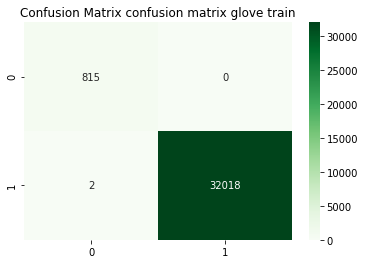

precision_score 0.9999984496517756
roc_auc_score-auc: 0.9999687695190507
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.99993754 1.        ]


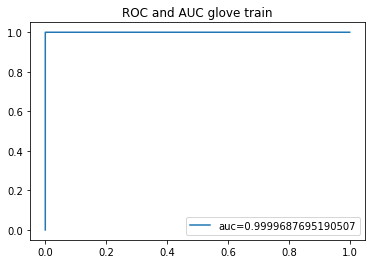

time :  0.7550733089447021
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       676
           1       1.00      1.00      1.00     21580

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9995956146657081
Precision: 0.999595359208135
Recall: 0.9995956146657081
F1 Score: 0.9995954699102836


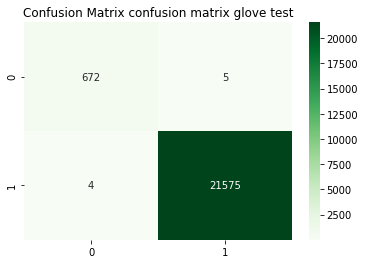

precision_score 0.9997627083472893
roc_auc_score-auc: 0.9962145551131109
roc_curve-fpr: [0.         0.00738552 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


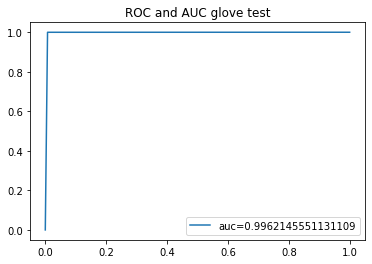

In [29]:
glove_model2 = wv.generate_model(num_classes)

glove_model2, device = kd.train(glove_model2, device, train_iter_kd, 
                                "glove", token_name, num_classes, num_epochs, model_path)
kd.predict(glove_model2, device, train_iter_kd, token_name, "glove train", num_classes)
kd.predict(glove_model2, device, test_iter_kd, token_name, "glove test", num_classes)

In [30]:
# student models
student_model = glove_model2

# teacher models
teachers = [lstm_model2, distilbert_model2]
teachers_name = ["lstm", "distilbert"]

# teachers = [distilbert_model, lstm_model, glove_model]
teacher_models = []
for idx, te_model in enumerate(teachers):
    # print(te_model)
    te_model.load_state_dict(torch.load(model_path + teachers_name[idx] + '.pth'))
    te_model#.to(device)
    # te_model.eval()  # eval mode
    teacher_models.append(te_model)
teacher_models

[LSTMModel(
   (embedding): Embedding(30000, 128)
   (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=2, bias=True)
 ), DistilBERTClassifierNetwork(
   (distil_bert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0): TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=Tr

epoch:  0 	 loss:  306.75304985418916
epoch:  1 	 loss:  306.298108920455
epoch:  2 	 loss:  305.99087402410805
epoch:  3 	 loss:  305.6186413615942
epoch:  4 	 loss:  307.2246010527015
epoch:  5 	 loss:  305.643574943766
epoch:  6 	 loss:  306.1899704039097
epoch:  7 	 loss:  307.57318640872836
epoch:  8 	 loss:  308.56172841601074
epoch:  9 	 loss:  312.9917101357132
time :  213.79892301559448
time :  1.2280619144439697
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       432
           1       1.00      0.99      0.99     32403

    accuracy                           0.99     32835
   macro avg       0.76      0.99      0.84     32835
weighted avg       0.99      0.99      0.99     32835

predicted label:  {0, 1}
Accuracy: 0.9880919750266484
Precision: 0.9881232831545531
Recall: 0.9880919750266484
F1 Score: 0.9862986738156343


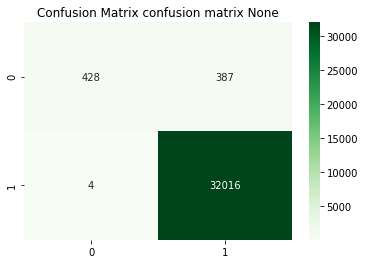

precision_score 0.988055052708622
roc_auc_score-auc: 0.7625142261546656
roc_curve-fpr: [0.         0.47484663 1.        ]
roc_curve-tpr: [0.         0.99987508 1.        ]


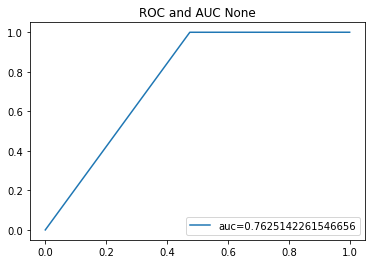

time :  0.7652387619018555
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       380
           1       1.00      0.99      0.99     21876

    accuracy                           0.99     22256
   macro avg       0.78      0.99      0.85     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.9862958303378864
Precision: 0.9863389745415879
Recall: 0.9862958303378864
F1 Score: 0.9844173363505951


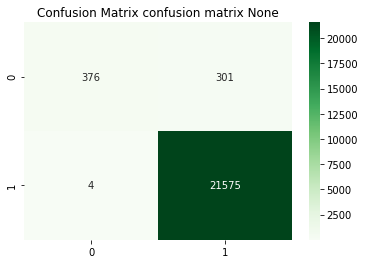

precision_score 0.9862375409248406
roc_auc_score-auc: 0.7776030336950903
roc_curve-fpr: [0.         0.44460857 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


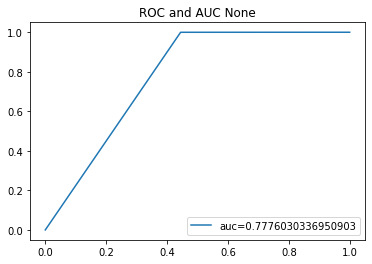

In [35]:
trained_student_model, device = kd.train_multi_teachers_kd(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs, model_path, "kd")
kd.predict(trained_student_model, device, train_iter_kd, "distilbert", None, num_classes)
kd.predict(trained_student_model, device, test_iter_kd, "distilbert", None, num_classes)

epoch:  0 	 loss:  308.44433355517685
epoch:  1 	 loss:  307.9953963160515
epoch:  2 	 loss:  308.75175289064646
epoch:  3 	 loss:  315.5653200186789
epoch:  4 	 loss:  317.0087154880166
epoch:  5 	 loss:  312.08234681375325
epoch:  6 	 loss:  310.99173348164186
epoch:  7 	 loss:  311.4676995072514
epoch:  8 	 loss:  309.89816967211664
epoch:  9 	 loss:  312.7061879839748
epoch:  10 	 loss:  310.2063089492731
epoch:  11 	 loss:  318.6907654553652
epoch:  12 	 loss:  312.3334517851472
epoch:  13 	 loss:  319.25585601106286
epoch:  14 	 loss:  312.9273377843201
epoch:  15 	 loss:  319.26799708791077
epoch:  16 	 loss:  315.0893166176975
epoch:  17 	 loss:  314.22854607738554
epoch:  18 	 loss:  317.11856362968683
epoch:  19 	 loss:  314.7848697081208
time :  427.26895356178284
time :  1.219106674194336
              precision    recall  f1-score   support

           0       0.50      0.99      0.66       412
           1       1.00      0.99      0.99     32423

    accuracy            

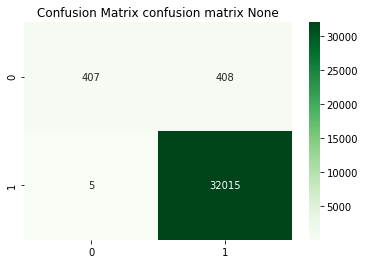

precision_score 0.9874144293504593
roc_auc_score-auc: 0.7496151753313688
roc_curve-fpr: [0.        0.5006135 1.       ]
roc_curve-tpr: [0.         0.99984385 1.        ]


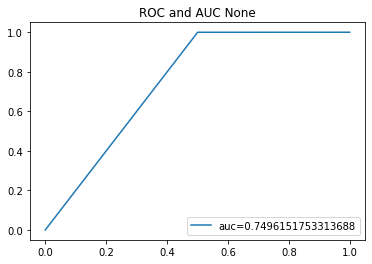

time :  0.761145830154419
              precision    recall  f1-score   support

           0       0.52      0.99      0.69       359
           1       1.00      0.99      0.99     21897

    accuracy                           0.99     22256
   macro avg       0.76      0.99      0.84     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.9853522645578721
Precision: 0.9854031758417525
Recall: 0.9853522645578721
F1 Score: 0.9831577743288942


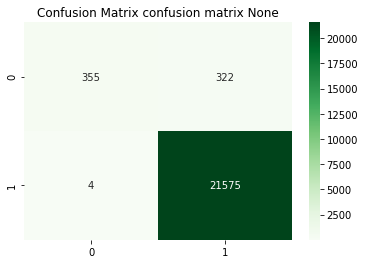

precision_score 0.9852918764915256
roc_auc_score-auc: 0.7620934325134063
roc_curve-fpr: [0.         0.47562777 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


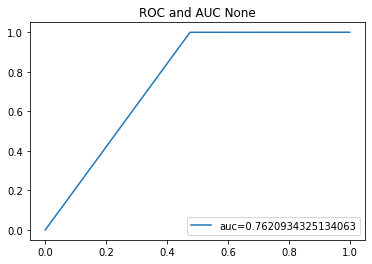

In [36]:
trained_student_model, device = kd.train_multi_teachers_kd(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, 20, model_path, "kd20epochs")
kd.predict(trained_student_model, device, train_iter_kd, "distilbert", None, num_classes)
kd.predict(trained_student_model, device, test_iter_kd, "distilbert", None, num_classes)

# Unmount and flush google drive

In [37]:
from google.colab import drive
drive.flush_and_unmount()